##### ARTI 560 - Computer Vision  
## Image Classification using Transfer Learning 

### Overview

**Transfer learning** is a machine learning technique where a model developed for one task is reused as the starting point for a different but related task. Instead of training a model from scratch, which can be time-consuming and require large datasets, transfer learning leverages the knowledge a pretrained model has already learned.

#### Key Concepts

1. **Pretrained Models**  
   - Models trained on large benchmark datasets (e.g., ImageNet) can capture general features such as edges, textures, and shapes in images.
   - Common pretrained models for image classification include **VGG16**, **ResNet**, **MobileNetV2**, and **EfficientNet**.

2. **Feature Extraction**  
   - The pretrained model is used as a fixed feature extractor.
   - Only the final layers (classifier) are replaced and trained on the new dataset.

3. **Fine-Tuning**  
   - A more advanced approach where some of the pretrained layers are "unfrozen" and trained on the new dataset.
   - Helps the model adapt more closely to the specific features of the new task.

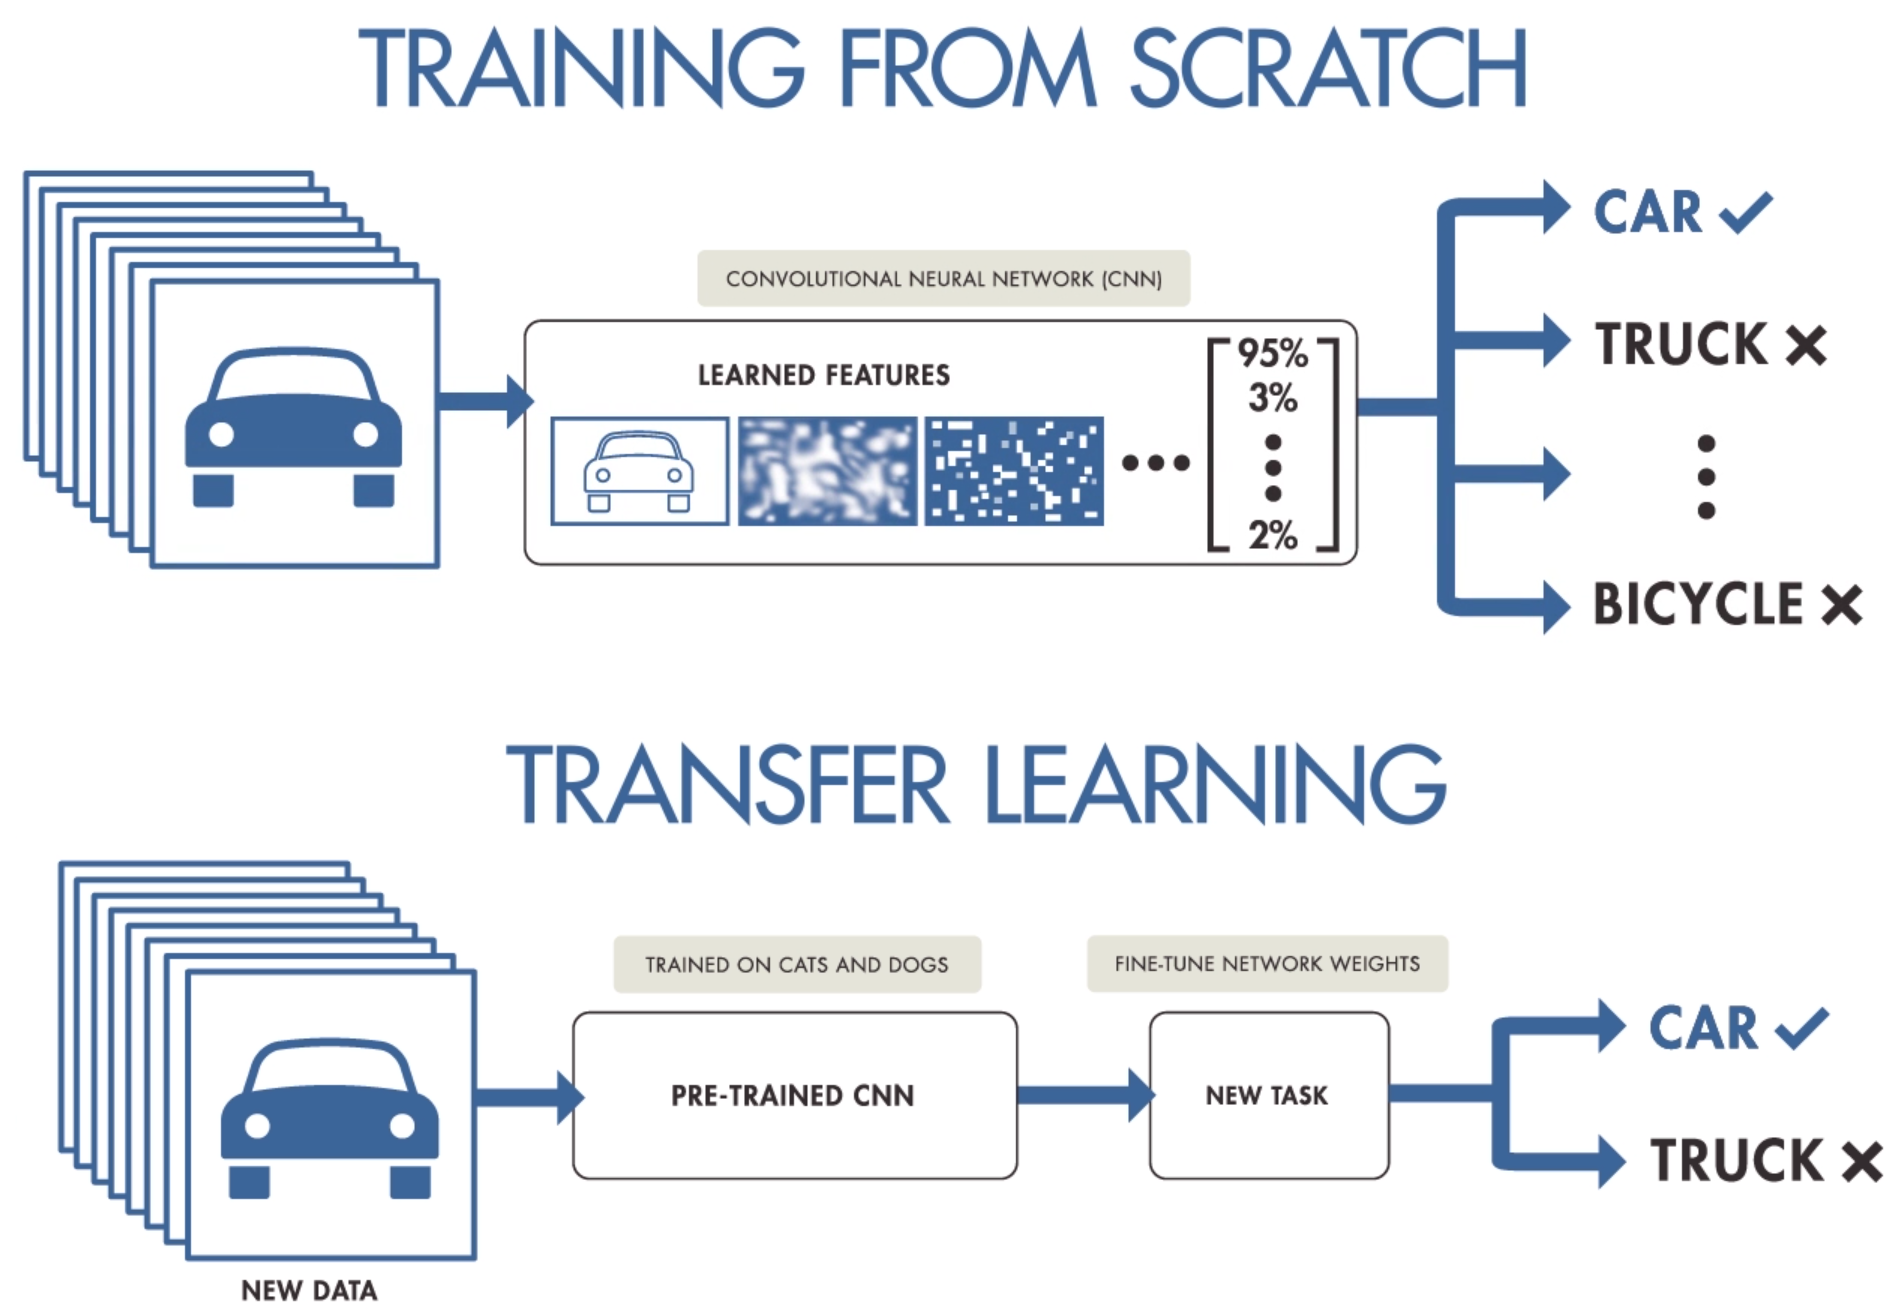

### Objective

In this lab, we will apply transfer learning with a pretrained ResNetV2 on CIFAR-10, fine-tune the model, and examine its architecture and trainable layers.

### Tools & Libraries
- Python  
- NumPy  
- TensorFlow
- Matplotlib  


### Transfer Learning using a Pre-trained ResNet

#### Steps:
1. Load a pre-trained ResNet50V2 model from `keras.applications` with ImageNet weights, excluding the top classification layer.
2. Resize the CIFAR-10 images to match the input size expected by ResNet (e.g., 224x224).
3. Build a new Keras Sequential model by adding the existing `data_augmentation` layer, followed by a resizing layer for input to ResNet, the loaded ResNet base model (freezing its layers), a `GlobalAveragePooling2D` layer, and a new `Dense` classification head (with 10 output units) for CIFAR-10.
4. Compile this model with an Adam optimizer, sparse categorical cross-entropy loss, and accuracy metrics, and train it on the preprocessed CIFAR-10 training data for a few epochs using early stopping callbacks.


#### Important: Pretrained model preprocessing

Pretrained models (ImageNet weights) expect inputs to be preprocessed *exactly* like during ImageNet training.
For ResNet50 in Keras, use:

`tf.keras.applications.resnet50.preprocess_input(...)`

If you skip this step, accuracy may drop close to random guessing.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input

# -----------------------------
# 1) Load CIFAR-10
# -----------------------------
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

class_names = [
    "airplane","automobile","bird","cat","deer",
    "dog","frog","horse","ship","truck"
]

# Keep labels as integers (SparseCategoricalCrossentropy)
y_train = y_train.squeeze().astype("int64")
y_test  = y_test.squeeze().astype("int64")

# Convert images to float32
x_train = x_train.astype("float32")
x_test  = x_test.astype("float32")

# -----------------------------
# 2) Data augmentation
# -----------------------------
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
], name="augmentation")

# -----------------------------
# 3) Build ResNet50V2 backbone (pretrained)
# -----------------------------
resnet_base = ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3)
)
resnet_base.trainable = False  # freeze first (feature extractor)

# -----------------------------
# 4) Full model (preprocess inside model)
# -----------------------------
resnet_model = keras.Sequential([
    layers.Input(shape=(32, 32, 3)),
    data_augmentation,
    layers.Resizing(224, 224, interpolation="bilinear"),
    layers.Lambda(preprocess_input),          # IMPORTANT
    resnet_base,
    layers.GlobalAveragePooling2D(),
    layers.Dense(10)                          
], name="cifar10_resnet50v2")

resnet_model.summary()

# -----------------------------
# 5) Compile + Train (frozen backbone)
# -----------------------------
resnet_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=1),
]

history = resnet_model.fit(
    x_train, y_train,
    validation_split=0.1,
    epochs=3,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "cifar10_resnet50v2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ augmentation (Sequential)       │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing (Resizing)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        20,490 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,585,290 (89.97 MB)

 Trainable params: 20,490 (80.04 KB)

 Non-trainable params: 23,564,800 (89.89 MB)

Epoch 1/3
704/704 ━━━━━━━━━━━━━━━━━━━━ 193s 257ms/step - accuracy: 0.6737 - loss: 0.9417 - val_accuracy: 0.8700 - val_loss: 0.3645 - learning_rate: 0.0010
Epoch 2/3
704/704 ━━━━━━━━━━━━━━━━━━━━ 179s 254ms/step - accuracy: 0.8059 - loss: 0.5613 - val_accuracy: 0.8814 - val_loss: 0.3389 - learning_rate: 0.0010
Epoch 3/3
704/704 ━━━━━━━━━━━━━━━━━━━━ 178s 252ms/step - accuracy: 0.8183 - loss: 0.5162 - val_accuracy: 0.8748 - val_loss: 0.3617 - learning_rate: 0.0010


Let's test our model

In [2]:

# -----------------------------
# 6) Test / Evaluate
# -----------------------------
test_loss, test_acc_r = resnet_model.evaluate(x_test, y_test, verbose=0)
print("ResNet50V2 (frozen) test accuracy:", test_acc_r)
print("ResNet50V2 (frozen) test loss    :", test_loss)


ResNet50V2 (frozen) test accuracy: 0.8758000135421753
ResNet50V2 (frozen) test loss    : 0.357622891664505


### Inspect the Model

In [3]:
# Print the total number of layers inside the ResNet50V2 backbone
print("Total layers in ResNet50V2 backbone:", len(resnet_base.layers))

# Filter only layers that actually have learnable parameters (weights/biases)
trainable_layers = [layer for layer in resnet_base.layers if layer.count_params() > 0]
    
# Print the number of layers that contain learnable parameters "Depth of the Model"
# It will be 102 (not 103) because ResNet50V2's classification head is NOT included as we are using only the backbone (feature extractor)
print("Layers with learnable parameters (depth):", len(trainable_layers))


Total layers in ResNet50V2 backbone: 190
Layers with learnable parameters (depth): 102


In [4]:
# Listing all layers that have learnable parameters (trainable_layers)
# Each layer will be printed with:
# (index in the filtered list, layer name, number of parameters)
for i, layer in enumerate(trainable_layers):
    print(i, layer.name, layer.count_params())

0 conv1_conv 9472
1 conv2_block1_preact_bn 256
2 conv2_block1_1_conv 4096
3 conv2_block1_1_bn 256
4 conv2_block1_2_conv 36864
5 conv2_block1_2_bn 256
6 conv2_block1_0_conv 16640
7 conv2_block1_3_conv 16640
8 conv2_block2_preact_bn 1024
9 conv2_block2_1_conv 16384
10 conv2_block2_1_bn 256
11 conv2_block2_2_conv 36864
12 conv2_block2_2_bn 256
13 conv2_block2_3_conv 16640
14 conv2_block3_preact_bn 1024
15 conv2_block3_1_conv 16384
16 conv2_block3_1_bn 256
17 conv2_block3_2_conv 36864
18 conv2_block3_2_bn 256
19 conv2_block3_3_conv 16640
20 conv3_block1_preact_bn 1024
21 conv3_block1_1_conv 32768
22 conv3_block1_1_bn 512
23 conv3_block1_2_conv 147456
24 conv3_block1_2_bn 512
25 conv3_block1_0_conv 131584
26 conv3_block1_3_conv 66048
27 conv3_block2_preact_bn 2048
28 conv3_block2_1_conv 65536
29 conv3_block2_1_bn 512
30 conv3_block2_2_conv 147456
31 conv3_block2_2_bn 512
32 conv3_block2_3_conv 66048
33 conv3_block3_preact_bn 2048
34 conv3_block3_1_conv 65536
35 conv3_block3_1_bn 512
36 conv

### Fine-tune ResNet

In this step, we fine-tune the pretrained network by unfreezing the last layers and training with a small learning rate. This allows the model to better adapt to CIFAR-10 while preserving useful pretrained features.

In [ ]:
# -----------------------------
#Fine-tune last layers
# -----------------------------
resnet_base.trainable = True
for layer in resnet_base.layers[:-30]:
    layer.trainable = False

print("Trainable layers in backbone:", sum(l.trainable for l in resnet_base.layers), "/", len(resnet_base.layers))

resnet_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

history_ft = resnet_model.fit(
    x_train, y_train,
    validation_split=0.1,
    epochs=3,
    batch_size=64,
    verbose=1
)

test_loss_ft, test_acc_ft = resnet_model.evaluate(x_test, y_test, verbose=0)
print("ResNet50V2 (fine-tuned) test accuracy:", test_acc_ft)
print("ResNet50V2 (fine-tuned) test loss    :", test_loss_ft)

Trainable layers in backbone: 30 / 190
Epoch 1/3
704/704 ━━━━━━━━━━━━━━━━━━━━ 226s 303ms/step - accuracy: 0.8003 - loss: 0.5889 - val_accuracy: 0.8984 - val_loss: 0.2843
Epoch 2/3
704/704 ━━━━━━━━━━━━━━━━━━━━ 209s 297ms/step - accuracy: 0.8643 - loss: 0.3953 - val_accuracy: 0.9072 - val_loss: 0.2495
Epoch 3/3
704/704 ━━━━━━━━━━━━━━━━━━━━ 209s 297ms/step - accuracy: 0.8856 - loss: 0.3305 - val_accuracy: 0.9184 - val_loss: 0.2286
ResNet50V2 (fine-tuned) test accuracy: 0.9161999821662903
ResNet50V2 (fine-tuned) test loss    : 0.24227656424045563
